# NLP Assignment 1 (40% of grade): Text classification for Fake News Detection

# This assignment has Final Model with solutions for Questions 5 and 6.¶

This coursework will involve you implementing functions for a text classifier, which you will train to detect **fake news** in a corpus of approx. 10,000 statements, which will be split into a 80%/20% training/test split. 

In this template you are given the basis for that implementation, though some of the functions are missing, which you have to fill in.

Follow the instructions file **NLP_Assignment_1_Instructions.pdf** for details of each question - the outline of what needs to be achieved for each question is as below.

You must submit all **ipython notebooks and extra resources you need to run the code if you've added them** in the code submission, and a **2 page report (pdf)** in the report submission on QMPlus where you report your methods and findings according to the instructions file for each question.

In [1]:
!pip install nltk


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Importing required modules

In [2]:
import csv    # csv reader
import numpy as np
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from sklearn import metrics
from sklearn.svm import LinearSVC
from nltk.classify import SklearnClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support # to report on precision and recall
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from sklearn.linear_model import PassiveAggressiveClassifier
from nltk.util import ngrams
from sklearn.metrics import classification_report

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pranj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pranj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
def load_data(path):
    """Load data from a tab-separated file and append it to raw_data."""
    with open(path, encoding='utf-8') as f:
        reader = csv.reader(f, delimiter='\t')
        for line in reader:
            if line[0] == "Id":  # skip header
                continue
            (label, text) = parse_data_line(line)
            raw_data.append((text, label))

def split_and_preprocess_data(percentage):
    """Split the data between train_data and test_data according to the percentage
    and performs the preprocessing."""
    num_samples = len(raw_data)
    num_training_samples = int((percentage * num_samples))
    for (text, label) in raw_data[:num_training_samples]:
        train_data.append((to_feature_vector(pre_process(text)),label))
    for (text, label) in raw_data[num_training_samples:]:
        test_data.append((to_feature_vector(pre_process(text)),label))

# Question 1: Input and Basic preprocessing (10 marks)

In [4]:
def convert_label(label):
    """Converts the multiple classes into two,
    making it a binary distinction between fake news and real."""
    #return label
    # Converting the multiclass labels to binary label
    labels_map = {
        'true': 'REAL',
        'mostly-true': 'REAL',
        'half-true': 'REAL',
        'false': 'FAKE',
        'barely-true': 'FAKE',
        'pants-fire': 'FAKE'
    }
    return labels_map[label]

def parse_data_line(data_line):
    """
    This method get the required columns from the given fake_news.tsv file.
    : param dataline: Row data from the given tsv file.
    : return: A tuple of label from the data and required columns from the data.
    """
    data_label = convert_label(data_line[1])
    
    # We are getting the only those rows where, Party Affiliation(data_column[7]) is not None and Last columns(data_column[13]) is not empty.
    # The columns which were added with the statement are: Statement, Subject, Speaker, Resource and party affiliation.
    # Earlier these columns were not consider but they hold valuable information, so they have added as a part of corpus.
    
    if data_line[7] != None and data_line[13] != None: 
        statement = data_line[2] + data_line[3] + data_line[4] + data_line[13] + data_line[7]
    return (data_label, statement)


In [5]:
def pre_process(text):
    """
    This methods uses different techniques to preprocess and clean data. 
    The method's which are commented are tried to verify accuracy using different techniques.
    For the final model, we have used a regex to clean the data and we have used Bigram method to get the features.
    :param text: a string of one statement
    :Return: A list of tokens
    """
    ## Below methods were used while performing multiple techniques in order to achieve good model.
#     tokens = count_vectorizing(text)
#     tokens = using_tfid(text)
#     tokens = normalizing_lamatizing(text)

    ## Regex and Bigram are used for the final model.
    tokens = using_regex(text)
    tokens = add_ngrams(tokens, 2)
    return tokens

In [6]:
def using_regex(text):
    """
    This method uses a Regex to separates punctuation at beginning and ends of strings. 
    After that, text is converted to list of words with each word converted to lower case.
    :param text: a string of one statement
    : return: tokens: list of words in text
    """
    text = re.sub(r"(\w)([.,;:!?'\"”\)])", r"\1 \2", text) # separates punctuation at ends of strings
    text = re.sub(r"([.,;:!?'\"“\(\)])(\w)", r"\1 \2", text) # separates punctuation at beginning of strings
    tokens = text.split()
    tokens = [word.lower() for word in tokens]
    return tokens

In [7]:
def count_vectorizing(text):
    """
    This method uses a count vectorizer to extract features from the given text. 
    For that, first, created a count vectorizer which by default does some pre-processing, 
    tokenizing and convert the words into lower case.
    :param text: a string of one statement
    : return tokens: list of words after performing data preprocessing and cleanup
    """
    count_vect = CountVectorizer()
    count_vect.fit_transform([text])
    tokens = count_vect.get_feature_names_out()
    return tokens

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
def using_tfid(text):
    """
    This method uses a tf-idf vectorizer to extract features from the given text. 
    The tf-idf vectorizer consider overall text of weight of words. This method also uses stop words with tfid, 
    to remove them if exists.
    :param text: a string of one statement
    : Return tokens: list of words after performing data preprocessing and cleanup
    """
    tfid_vect = TfidfVectorizer(stop_words='english')
    X = tfid_vect.fit_transform([text])
    tokens = tfid_vect.get_feature_names_out()
    return tokens

In [9]:
def add_ngrams(tokens, n):
    """
    This method can convert tokens to given add ngrams.
    : param tokens: Input list of words/tokens
    : param n: number of ngram need to use.
    : return: return a list of tokens based on ngram size.
    """
    return list(ngrams(tokens, n))

In [10]:
def normalizing_lamatizing(tokens):
    """
    This method performs multiple data cleaning steps, such as removing stopwords, 
    removing punctuation, and performs stemming(Stemming means reducing inflection in words to their root forms).
    : return: a list of tokens after cleaning.
    """
    # removing stopwords
    tokens_without_sw = [w for w in tokens if not w.lower() in stopwords.words('english')]
    tokes_without_pucn = [w.lower() for w in tokens_without_sw if w.isalpha()]
    sb = SnowballStemmer('english')
    tokens_after_stem = [sb.stem(w) for w in tokes_without_pucn]
    return tokens_after_stem

# Question 2: Basic Feature Extraction (20 marks)

In [11]:
global_feature = [] # A global list of features

def to_feature_vector(tokens):
    """
    This method returns a dictionary containing features as keys, and weights as values.
    Add every new word in dictionary as a key and assign it value as 1. 
    If word already exists in dictionary then just increase its weight by 1.
    Also, maintains a list (global_feature) to get the all unique words in the given corpus.
    : param tokens: List of words
    : return feature_vector_dict: a dict = {'words': frequency} for given tokens
    """
    feature_vector_dict = {}
    for word in tokens:
      if word not in global_feature:
        global_feature.append(word)

      if word in feature_vector_dict:
        feature_vector_dict[word] += 1
      else:
          feature_vector_dict[word] = 1

    return feature_vector_dict

In [12]:
# TRAINING AND VALIDATING OUR CLASSIFIER

def train_classifier(data):
    print("Training Classifier...")
    pipeline =  Pipeline([('svc', LinearSVC())])
    return SklearnClassifier(pipeline).train(data)


# Question 3: Cross-validation (20 marks)

In [13]:
def cross_validate(dataset, folds):
    """
    This method performs 10 folds cross validation on Training dataset by diving the 
    training dataset into train and test dataset.
    : param dataset: Training Dataset (80% of total dataset)
    : param folds: Number of folds, 10
    :returns: 
    cv_results: Average of presicion, recall, fscore, accuracy of each fold
    first_fold_actual_label: list of First fold Actual Label
    first_fold_predicted_label: list of First fold Predicted Label
    """
    fold_size = int(len(dataset)/folds) + 1
    results = []

    for i in range(0, len(dataset), int(fold_size)):
        # trains and tests on the 10 folds of data in the dataset
        print("Fold start on items %d - %d" % (i, i+fold_size))
        test_data = dataset[i:i+fold_size]
        if i == 0:
            train_data = dataset[i+fold_size:]
        else:
            train_data = dataset[:i] + dataset[i+fold_size:]

        #Training classifier with train data
        classifier = train_classifier(train_data)
        actual_label = []
        predicted_label = []

        #Predicting label for each sample of test data
        for j in range(0, len(test_data)):
            actual_label.append(test_data[j][1])
            pred_label = predict_labels(test_data[j][0], classifier)
            predicted_label.append(pred_label[0])

        # Getting presicion, recall, fscore and accuracy
        presicion, recall, fscore, support = precision_recall_fscore_support(actual_label, predicted_label, average='weighted')
        accuracy = accuracy_score(actual_label, predicted_label)
        results.append([presicion, recall, fscore, accuracy])

        # Appening classification report of each fold in ClassificatioReportforEachFold file.
        with open("Classification_Report_for_Each_Fold_Final_notebook.txt", "a+") as f:
            f.write(f"\n =============Classification report for {i, i+fold_size} fold=======================")
            f.write(f"\n{classification_report(actual_label, predicted_label)}")
            f.write(f"\n Confusion matrix: \n{str(metrics.confusion_matrix(actual_label, predicted_label))}")

        # Getting fist fold's actual and predicted labels
        if i == 0:
            first_fold_actual_label = actual_label
            first_fold_predicted_label = predicted_label

    cv_result = [sum(val)/len(results) for val in zip(*results)]
    return cv_result, first_fold_actual_label, first_fold_predicted_label

In [14]:
# PREDICTING LABELS GIVEN A CLASSIFIER

def predict_labels(samples, classifier):
    """Assuming preprocessed samples, return their predicted labels from the classifier model."""
    return classifier.classify_many(samples)

def predict_label_from_raw(sample, classifier):
    """Assuming raw text, return its predicted label from the classifier model."""
    return classifier.classify(to_feature_vector(preProcess(reviewSample)))

In [15]:
# MAIN

# loading reviews
# initialize global lists that will be appended to by the methods below
raw_data = []          # the filtered data from the dataset file
train_data = []        # the pre-processed training data as a percentage of the total dataset
test_data = []         # the pre-processed test data as a percentage of the total dataset

# references to the data files
data_file_path = 'fake_news.tsv'

# Do the actual stuff (i.e. call the functions we've made)
# We parse the dataset and put it in a raw data list
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing the dataset...",sep='\n')

load_data(data_file_path)

# We split the raw dataset into a set of training data and a set of test data (80/20)
# You do the cross validation on the 80% (training data)
# We print the number of training samples and the number of features before the split
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing training and test data...",sep='\n')

split_and_preprocess_data(0.8)


# We print the number of training samples and the number of features after the split
print("After split, %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Training Samples: ", len(train_data), "Features: ", len(global_feature), sep='\n')

Now 0 rawData, 0 trainData, 0 testData
Preparing the dataset...
Now 10241 rawData, 0 trainData, 0 testData
Preparing training and test data...
After split, 10241 rawData, 8192 trainData, 2049 testData
Training Samples: 
8192
Features: 
113857


In [16]:
cv_results, first_fold_actual_label, first_fold_predicted_label = cross_validate(train_data, 10) # will work and output overall performance of p, r, f-score when cv implemented
print(f"\n\nAverage Results of presicion, recall, fscore, accuracy: {cv_results}")

Fold start on items 0 - 820
Training Classifier...
Fold start on items 820 - 1640
Training Classifier...
Fold start on items 1640 - 2460
Training Classifier...
Fold start on items 2460 - 3280
Training Classifier...
Fold start on items 3280 - 4100
Training Classifier...
Fold start on items 4100 - 4920
Training Classifier...
Fold start on items 4920 - 5740
Training Classifier...
Fold start on items 5740 - 6560
Training Classifier...
Fold start on items 6560 - 7380
Training Classifier...
Fold start on items 7380 - 8200
Training Classifier...


Average Results of presicion, recall, fscore, accuracy: [0.596747412244935, 0.5993704193199567, 0.5967956503093932, 0.5993704193199567]


# 4. Error Analysis (10 marks)

In [17]:
from sklearn import metrics
import matplotlib.pyplot as plt
# a function to make the confusion matrix readable and pretty
def confusion_matrix_heatmap(y_test, preds, labels):
    """Function to plot a confusion matrix"""
    # pass labels to the confusion matrix function to ensure right order
    cm = metrics.confusion_matrix(y_test, preds, labels=labels)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!
    plt.show()

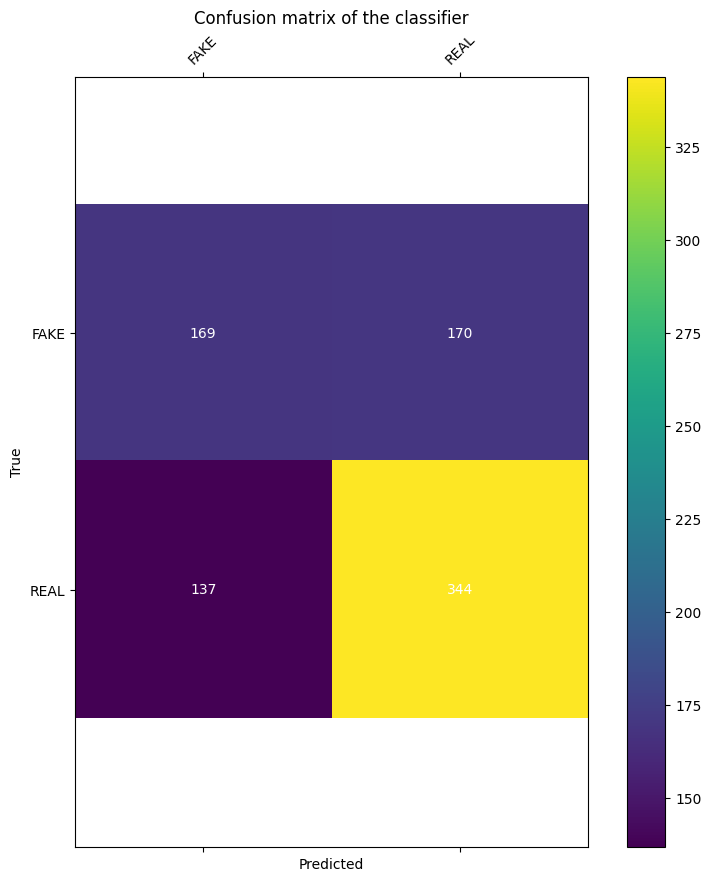


Final Classification Report for first fold: 

               precision    recall  f1-score   support

        FAKE       0.55      0.50      0.52       339
        REAL       0.67      0.72      0.69       481

    accuracy                           0.63       820
   macro avg       0.61      0.61      0.61       820
weighted avg       0.62      0.63      0.62       820



In [18]:
labels = ['FAKE', 'REAL']
confusion_matrix_heatmap(first_fold_actual_label, first_fold_predicted_label, labels)

report = classification_report(first_fold_actual_label, first_fold_predicted_label)
print(f"\nFinal Classification Report for first fold: \n\n {report}")

with open("Classification_Report_for_Each_Fold_Final_notebook.txt", "a+") as f:
    f.write(f"\n ============Classification Report for First Fold==============\n")
    f.write(f"\n\n{report}")

# Questions 5 (20%) and 6 (20%) (recommend starting a new notebook)

({('the', 'bush'): 1, ('bush', 'tax'): 1, ('tax', 'cuts'): 1, ('cuts', 'helped'): 1, ('helped', 'to'): 1, ('to', 'create'): 1, ('create', 'a'): 1, ('a', 'substantial'): 1, ('substantial', 'part'): 1, ('part', 'of'): 1, ('of', 'the'): 1, ('the', 'deficit'): 1, ('deficit', '.'): 1, ('.', 'bush-administration'): 1, ('bush-administration', ','): 1, (',', 'deficit'): 1, ('deficit', ','): 1, (',', 'taxesdennis-kucinicha'): 1, ('taxesdennis-kucinicha', 'radio'): 1, ('radio', 'interviewdemocrat'): 1}, 'REAL')
Training Classifier...


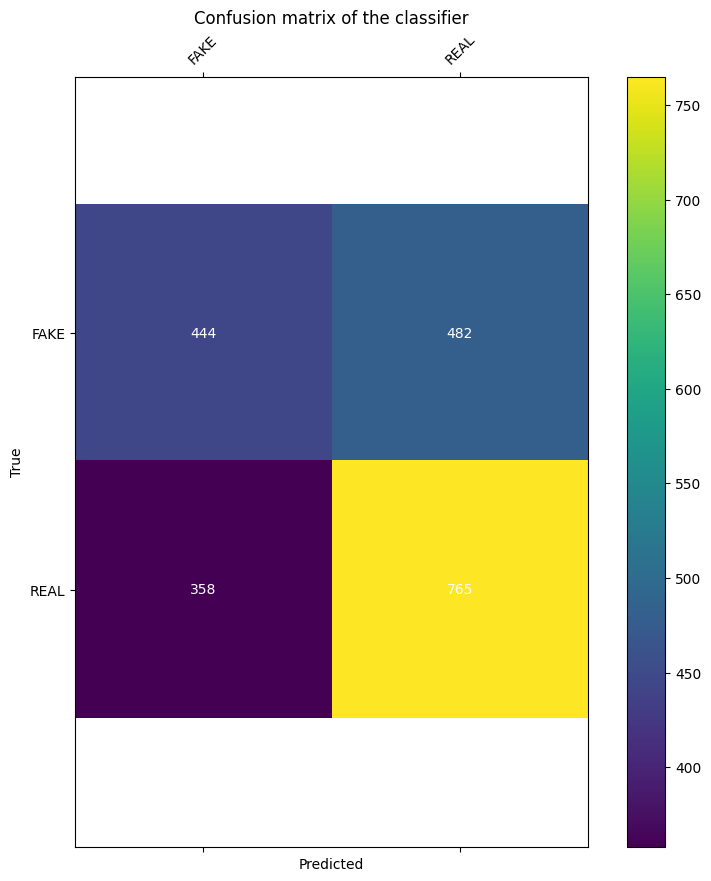

Done training!
Precision: 0.586422
Recall: 0.590044
F Score:0.586059
Classification report:               precision    recall  f1-score   support

        FAKE       0.55      0.48      0.51       926
        REAL       0.61      0.68      0.65      1123

    accuracy                           0.59      2049
   macro avg       0.58      0.58      0.58      2049
weighted avg       0.59      0.59      0.59      2049



In [19]:
# Finally, check the accuracy of your classifier by training on all the traning data
# and testing on the test set
# Will only work once all functions are complete
functions_complete = True  # set to True once you're happy with your methods for cross val
if functions_complete:
    print(test_data[0])   # have a look at the first test data instance
    classifier = train_classifier(train_data)  # train the classifier
    test_true = [t[1] for t in test_data]   # get the ground-truth labels from the data
    test_pred = predict_labels([x[0] for x in test_data], classifier)  # classify the test data to get predicted labels
    final_scores = precision_recall_fscore_support(test_true, test_pred, average='weighted')# evaluate
    report = classification_report(test_true, test_pred) # Getting classification report 
    labels = ['FAKE', 'REAL']
    confusion_matrix_heatmap(test_true, test_pred, labels)
    print("Done training!")
    print("Precision: %f\nRecall: %f\nF Score:%f" % final_scores[:3])
    print(f"Classification report: \n\n{report}")
